# TalkingData AdTracking Fraud Detection - Can you detect fraudulent click traffic for mobile app ads?

###### Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.
###### TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.
###### While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import datetime
import calendar
import numpy as np
from string import punctuation
from __future__ import division
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
import re
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
plt.style.use('fivethirtyeight')
from IPython.core.debugger import Pdb 
import time
from datetime import datetime
from dateutil.parser import parse


###### File descriptions
* train.csv - the training set
* train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
* test.csv - the test set

In [2]:
train_data = pd.read_csv("train.csv",sep=',',parse_dates=True)
train_sample_data = pd.read_csv("train_sample.csv",sep=',',parse_dates=True)
test_supplement_data = pd.read_csv("test_supplement.csv",sep=',',parse_dates=True)
test_data = pd.read_csv("test.csv",sep=',',parse_dates=True)

###### Each row of the training data contains a click record, with the following features.
* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded


* Note that ip, app, device, os, and channel are encoded.
* The test data is similar, with the following differences:
* click_id: reference for making predictions
* is_attributed: not included

In [3]:
train_sample_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [4]:
#Creating a DataFrame copy of the training sample data
df_train_sample = train_sample_data.copy()

In [5]:
df_train_sample.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

In [6]:
df_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


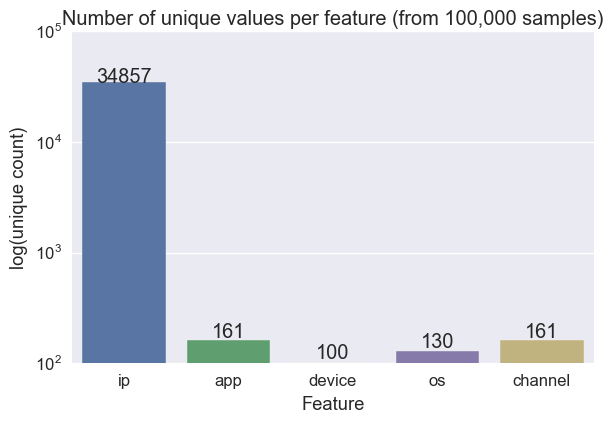

In [9]:
# The plot below shows the number of unique values of IP, app, device, os and channel
# The 34,857 unique IPs is an indication that since the IPs are not 100000 there are duplicate ips that are causing hits 
# This together with small number of unique devices 
# - this proves that the device IPs are part of a network and the IPs listed here could be network IPs instead.

plt.figure(figsize=(6, 4))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(df_train_sample[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 100,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [12]:
# df_train_sample['ClickYear'] = [parse(clicktime).year for clicktime in df_train_sample['click_time']]
# df_train_sample['ClickMonth'] = [parse(clicktime).month for clicktime in df_train_sample['conv_clicktime']]
# df_train_sample['ClickDate'] = [parse(clicktime).day for clicktime in df_train_sample['conv_clicktime']]
# df_train_sample['ClickDayofWeek'] = [parse(clicktime).weekday() for clicktime in df_train_sample['conv_clicktime']]

# df_train_sample['AttributedYear'] = [parse(attributedtime).year for attributedtime in df_train_sample['conv_attributedtime']]
# df_train_sample['AttributedMonth'] = [parse(attributedtime).month for attributedtime in df_train_sample['conv_attributedtime']]
# df_train_sample['AttributedDate'] = [parse(attributedtime).day for attributedtime in df_train_sample['conv_attributedtime']]
# df_train_sample['AttributedDayofWeek'] = [parse(attributedtime).weekday() for attributedtime in df_train_sample['conv_attributedtime']]

###### Filtering out the records where the app was successfully downloaded == 227 downloads outof 100,000 shows sample bias

In [10]:
train_sample_downloaddata = train_sample_data.query('is_attributed == 1')
# train_sample_downloaddata

In [11]:
train_sample_data.is_attributed.value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [12]:
train_sample_downloaddata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 284 to 99562
Data columns (total 8 columns):
ip                 227 non-null int64
app                227 non-null int64
device             227 non-null int64
os                 227 non-null int64
channel            227 non-null int64
click_time         227 non-null object
attributed_time    227 non-null object
is_attributed      227 non-null int64
dtypes: int64(6), object(2)
memory usage: 16.0+ KB


In [13]:
# Unique IPs that were used for downloads
grps_ips_downloaded = pd.unique(train_sample_downloaddata.ip.values)
print(np.sort(grps_ips_downloaded))

[  2948   4865   5281   5314   5348   5729   6192   6481   7350   7909
   8180  11467  11967  12506  14888  15195  16535  17460  18204  20806
  22109  24458  29016  31277  31859  32247  32463  34399  35308  38943
  40352  40654  42074  44067  46364  48072  48337  48733  52118  53389
  55142  56317  57153  58560  60666  62779  63776  65214  69145  71579
  75443  76989  79001  83309  85364  85536  85928  86812  88914  89457
  93542  93996  94466  95207  95347  96637  97935 102174 102511 103059
 104110 110652 111025 112271 113865 115265 115655 116718 116785 118252
 120148 120259 127369 127848 131029 131817 133843 137168 137509 140132
 147184 149586 152799 157074 160155 161034 161986 163333 163797 164933
 166691 167515 171892 174091 176243 177454 177515 177975 178824 179080
 179136 180418 180702 182506 182552 182605 184467 185536 186843 187270
 187652 188617 193539 196491 199419 199488 199733 201234 202255 202934
 204203 209480 210641 211364 211731 214819 215229 215624 218061 218863
 22057

In [14]:
# Unique Apps that were downloaded
grps_apps_downloaded = pd.unique(train_sample_downloaddata.app.values)
print(np.sort(grps_apps_downloaded))

[  3   5   8   9  10  11  12  15  18  19  20  29  32  34  35  39  45  48
  50  58  60  62  71  72  83  84  96 103 107 108 115 116 125 145 202 208
 261]


In [15]:
# Unique Devices that were used for downloads
grps_devices_downloaded = pd.unique(train_sample_downloaddata.device.values)
print(np.sort(grps_devices_downloaded))

[  0   1   2   4   6  16  21  30  33  36  40  50  56  60  74  97 102 109
 116 180 188 351 579 581 957]


In [16]:
# Unique OS that were used for downloads
grps_os_downloaded = pd.unique(train_sample_downloaddata.os.values)
print(np.sort(grps_os_downloaded))

[  0   1   2   3   4   6   7   9  10  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  31  32  35  36  37  38  43  47  59
  61 748 866]


In [17]:
# Unique channels that were involved in the downloads
grps_channels_downloaded = pd.unique(train_sample_downloaddata.channel.values)
print(np.sort(grps_channels_downloaded))

[  3   5  21 101 107 113 114 120 121 130 134 145 171 173 203 213 243 265
 268 274 280 282 320 333 341 343 347 377 379 419 421 439 442 445 449 465
 466 478 487 489]


In [18]:
train_sample_downloaddata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 284 to 99562
Data columns (total 8 columns):
ip                 227 non-null int64
app                227 non-null int64
device             227 non-null int64
os                 227 non-null int64
channel            227 non-null int64
click_time         227 non-null object
attributed_time    227 non-null object
is_attributed      227 non-null int64
dtypes: int64(6), object(2)
memory usage: 16.0+ KB


###### Changing types of the time variables from object to datetime

In [19]:
train_sample_downloaddata['conv_clicktime'] = [time.strftime('%Y%m%d %H%M%S', time.strptime(clicktime, '%Y-%m-%d %H:%M:%S')) for clicktime in train_sample_downloaddata['click_time']]
# train_sample_downloaddata

train_sample_downloaddata['conv_attributedtime'] = [time.strftime('%Y%m%d %H%M%S', time.strptime(attributedtime, '%Y-%m-%d %H:%M:%S')) for attributedtime in train_sample_downloaddata['attributed_time']]
# train_sample_downloaddata

train_sample_downloaddata['conv_clicktime'] = pd.to_datetime(train_sample_downloaddata['conv_clicktime'])

train_sample_downloaddata['conv_attributedtime'] = pd.to_datetime(train_sample_downloaddata['conv_attributedtime'])

C:\Program Files\Anaconda33\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Program Files\Anaconda33\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda33\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [20]:
# new_x and new_y provide the Series data for clicktie and attributedtime - helpful for Time-Series plotting

new_x = train_sample_downloaddata['conv_clicktime']
new_y = train_sample_downloaddata['conv_attributedtime']

In [21]:
# This gets the difference in time = (downloadtime - clicktime)
# newdiff is in seconds

newdiff = list()
for i in range(0,len(new_x)):
    newdiff[:i] = np.subtract(new_y[:i],new_x[:i]) 

# newdiff in seconds
newdiff_sec= (pd.to_timedelta(newdiff,unit='d')+pd.to_timedelta(0,unit='s')).astype('timedelta64[s]')

newdiff_sec

Int64Index([   25,    32,  7483,  3195, 12959,  2680, 13508,     4,   145,
             5969,
            ...
               36,   315,   193,    36,   141,    12,    86,  3657,   110,
               46],
           dtype='int64', length=226)

In [23]:
latest_sample = zip(train_sample_downloaddata, newdiff_sec)
latest_sample

In [24]:
newdiff_sec = pd.DataFrame(newdiff_sec)

In [25]:
newdiff_sec.mean()

0    4356.977876
dtype: float64

In [26]:
newdiff_sec.median()

0    195.5
dtype: float64

In [27]:
newdiff_sec.mode()

,0
0,31


###### The newdiff data in seconds shows that the time between clicking on the app and the download time
###### The range of this is 2 sec to 46,341 (12.9 hours)

In [28]:
np.sort(pd.unique(newdiff_sec[0]))

array([    2,     3,     4,     9,    10,    11,    12,    13,    15,
          21,    22,    23,    24,    25,    27,    28,    29,    31,
          32,    33,    34,    35,    36,    38,    46,    49,    50,
          51,    52,    53,    54,    55,    56,    57,    58,    60,
          61,    64,    68,    70,    71,    72,    76,    83,    84,
          86,    93,    95,    97,    98,    99,   101,   103,   105,
         106,   110,   117,   123,   140,   141,   143,   144,   145,
         153,   155,   164,   166,   178,   192,   193,   198,   205,
         215,   219,   229,   247,   253,   254,   279,   315,   322,
         337,   341,   348,   373,   397,   405,   458,   504,   523,
         584,   729,   733,   763,   796,   889,   974,  1008,  1029,
        1155,  1165,  1206,  1207,  1219,  1260,  1318,  1323,  1392,
        1661,  1860,  1946,  2120,  2252,  2386,  2388,  2427,  2476,
        2523,  2680,  2705,  2858,  3195,  3657,  3733,  4473,  4485,
        4594,  5181,

In [29]:
newdiff_sec.describe()

,0
count,226.000000
mean,4356.977876
std,8454.851266
min,2.000000
25%,52.250000
50%,195.500000
75%,4566.750000
max,46341.000000


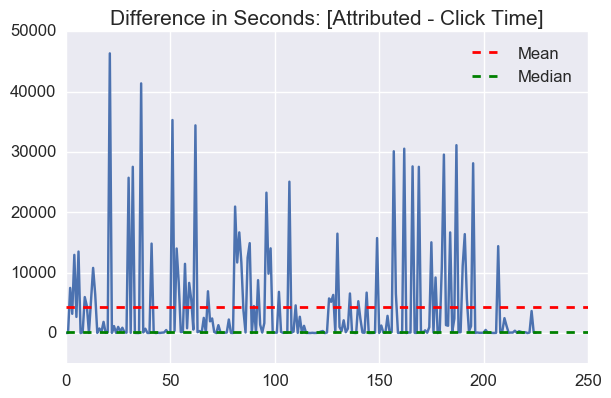

In [62]:
plt.plot(newdiff_sec)
plt.axhline(y=newdiff_sec.mean()[0],lw=2,ls='--',color='r',label='Mean')
plt.axhline(y=newdiff_sec.median()[0],lw=2,ls='--',color='g',label='Median')
# plt.axhline(y=newdiff_sec.mode()[0][0],lw=2,ls='--',color='c',label='Mode')
plt.title('Difference in Seconds: [Attributed - Click Time]', fontsize= 15)
plt.ylim(-5000,50000)
plt.legend()

###### No pattern can be seen in the above plot for the number of seconds between clicktime and downloadtime

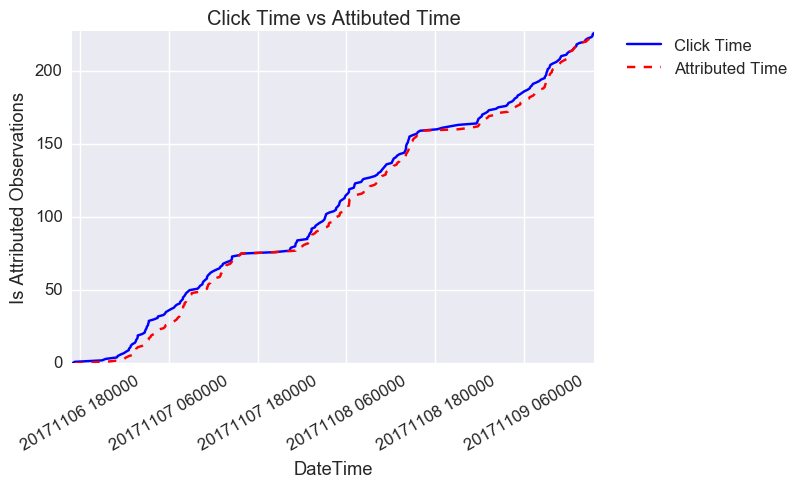

In [31]:
from matplotlib.dates import DateFormatter

# a= np.datetime(new_x).astype(datetime)
fig, ax = plt.subplots()
# ax.scatter(new_x.tolist(),new_y.tolist(), 'b^')
ax.plot(new_x.sort_values().tolist(),np.arange(len(new_x)),'b-', label="Click Time")
ax.plot(new_y.sort_values().tolist(),np.arange(len(new_y)),'r--', label="Attributed Time")
# ax.bar(newdiff_sec,'go', label="Difference in Click & Attributed Time")
_ = plt.title('Click Time vs Attibuted Time')
# Label the axes
_ = plt.xlabel('DateTime')
_ = plt.ylabel('Is Attributed Observations')
plt.xlim(new_x.min(),new_y.max())
plt.ylim(0,len(new_x))
myFmt = DateFormatter("%Y%m%d %H%M%S")
ax.xaxis.set_major_formatter(myFmt)
# plt.set_xticks(xlabels)
plt.xticks(rotation = '30')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# plt.grid(True)
plt.show()


###### The above plot potrays the lag between attributed/download time and the click time on the 4 days of training sample collection

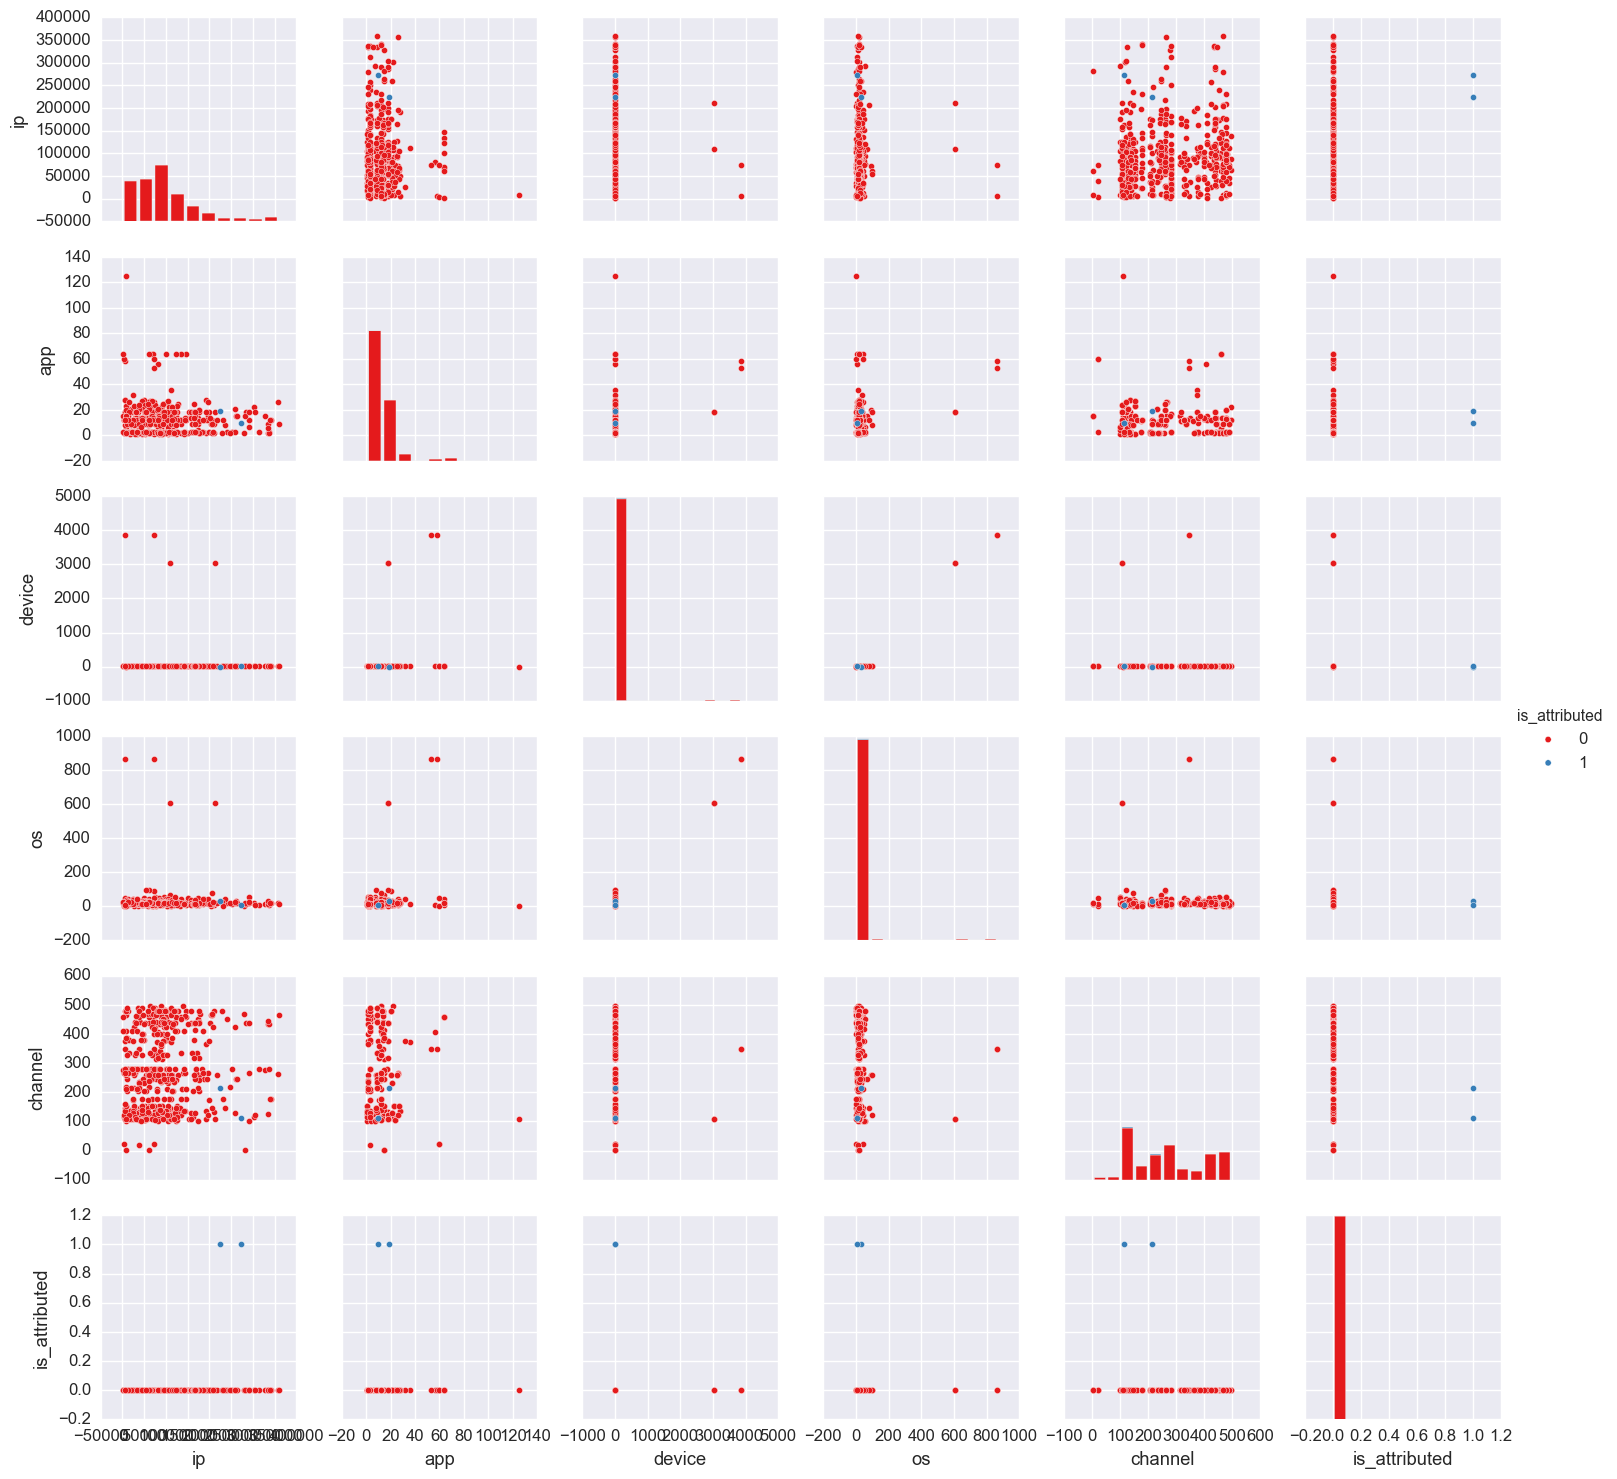

In [34]:
import seaborn as sns
sns.pairplot(train_sample_data.head(500),hue='is_attributed',palette='Set1')

###### Feature Engineering to get the Click Day,Hour, Minute and Second extracted

In [35]:
train_sample_data_copy = df_train_sample.copy()

train_sample_data_copy['click_time'] = pd.to_datetime(train_sample_data_copy['click_time'])

train_sample_data_copy['click_day'] = train_sample_data_copy['click_time'].dt.day.astype('uint8')
train_sample_data_copy['click_hour'] = train_sample_data_copy['click_time'].dt.hour.astype('uint8')
train_sample_data_copy['click_minute'] = train_sample_data_copy['click_time'].dt.minute.astype('uint8')
train_sample_data_copy['click_second'] = train_sample_data_copy['click_time'].dt.second.astype('uint8')

###### Begin Data Modeling; Get X and y to start training the model

In [36]:
y = train_sample_data_copy['is_attributed']
X = train_sample_data_copy.drop(['click_time','attributed_time','is_attributed'],axis=1)

In [37]:
train_sample_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null datetime64[ns]
attributed_time    227 non-null object
is_attributed      100000 non-null int64
click_day          100000 non-null uint8
click_hour         100000 non-null uint8
click_minute       100000 non-null uint8
click_second       100000 non-null uint8
dtypes: datetime64[ns](1), int64(6), object(1), uint8(4)
memory usage: 6.5+ MB


###### Splitting the training and validation data in order to train and validate the model

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,y,random_state=12)

In [39]:
# Importing necessary packages for running the modeling algorithms against the data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [40]:
# Using Random Forest Classifier as first modelling technique

clf_plainrf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_plainrf.fit(x_train, y_train)

print('Validation Results')
print(clf_plainrf.score(x_val, y_val))
print(recall_score(y_val, clf_plainrf.predict(x_val)))

Validation Results
0.99788
0.04


###### Since the data is imbalanced I wanted to use the SMOTE algorithm in order to remove bias and then fit the model with the new x, y values

In [41]:
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

C:\Program Files\Anaconda33\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [43]:
# Using Random Forest Classifier after SMOTE as second modelling technique

clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)

print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))

Validation Results
0.99712
0.2


In [44]:
# Working with the provided test data

test_data_copy = test_data.copy()
test_data_copy.dropna(inplace=True)

test_data_copy['click_time'] = pd.to_datetime(test_data_copy['click_time'])

test_data_copy['click_day'] = test_data_copy['click_time'].dt.day.astype('uint8')
test_data_copy['click_hour'] = test_data_copy['click_time'].dt.hour.astype('uint8')
test_data_copy['click_minute'] = test_data_copy['click_time'].dt.minute.astype('uint8')
test_data_copy['click_second'] = test_data_copy['click_time'].dt.second.astype('uint8')

test_data_copy.drop(['click_id','click_time'],axis = 1,inplace=True)

X_test = test_data_copy

test_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 9 columns):
ip              int64
app             int64
device          int64
os              int64
channel         int64
click_day       uint8
click_hour      uint8
click_minute    uint8
click_second    uint8
dtypes: int64(5), uint8(4)
memory usage: 931.8 MB


In [46]:
# Predicting using Random Forest Classifier using test values

y_test = clf_rf.predict(X_test)

In [48]:
# Predicting using XGBoost Classifier using test values
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(x_train_res, y_train_res)
y_xgb_test = model_xgb.predict(X_test.values)

print('Validation Results')
print(model_xgb.score(x_val.values, y_val.values))
print(recall_score(y_val, model_xgb.predict(x_val.values)))

C:\Program Files\Anaconda33\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Validation Results
0.97584
0.74


C:\Program Files\Anaconda33\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Program Files\Anaconda33\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
import collections

In [50]:
collections.Counter(y_train)

Counter({0: 74823, 1: 177})

In [51]:
# shows the 0,1 split after running SMOTE which smoothes out the bias

collections.Counter(y_train_res)

Counter({0: 74823, 1: 74823})

In [52]:
collections.Counter(y_val)

Counter({0: 24950, 1: 50})

In [53]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 9 columns):
ip              int64
app             int64
device          int64
os              int64
channel         int64
click_day       uint8
click_hour      uint8
click_minute    uint8
click_second    uint8
dtypes: int64(5), uint8(4)
memory usage: 931.8 MB


In [54]:
collections.Counter(y_test)

Counter({0: 18783358, 1: 7111})

In [55]:
# There is a boost in the conversions after running XGBoost Classifier on the test data

collections.Counter(y_xgb_test)

Counter({0: 18710834, 1: 79635})

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('\nRandom Forest Classifier Test Results')
y_pred = []
y_pred = np.random.choice(y_test, size=(25000), replace=True)


accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# recall = recall_score(y_val, y_pred)
# print("Recall Score: %f%%" % (recall))
# # report = classification_report(y_val, y_pred)
# # print(report)


Random Forest Classifier Test Results
Accuracy: 99.76%


In [60]:

print('\nXGBoost Test Results')
y_xgb_pred = []
y_xgb_pred = np.random.choice(y_xgb_test, size=(25000), replace=True)


accuracy = accuracy_score(y_val, y_xgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# recall = recall_score(y_val, y_pred)
# print("Recall Score: %f%%" % (recall))
# report = classification_report(y_val, y_xgb_pred)
# print(report)


XGBoost Test Results
Accuracy: 99.29%


###### Loading data -- a small subset of the data for more speedy testing

In [63]:
import gc

In [64]:
# Load subset of the training data
X_train = pd.read_csv('train.csv', nrows=1000000, parse_dates=['click_time'])

In [65]:
# Show the head of the table
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


### Creating Features

###### Extracting time information

In [66]:
# First extract day, minute, hour, second from the click_time.

X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,33,34
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,34,12
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,34,52
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,35,8


###### Confidence Rates for is_attributed

<div class="span5 alert alert-info">

<p>My thought is that some ips, apps, devices, etc. might have higher frequencies of is_attributed, and I wish to add that information, i.e. I'm calculating the following "attributed rates":</p>

<p>P(is_attributed|category)
or in some cases two- or multiple-paired combinations:</p>

<p>P(is_attributed|category_1, category_2)
The danger of this is that if a given category-combination has very few clicks, then the statistical significance of above equations cannot be trusted. Therefore I'll be weighing the rates by the following confidence rates:</p>

<p>conf_is_attributed=log(viewscategory_1)log(100000)
where the value 100000 has been chosen arbitrarily to such that if a given category has 1000 views, then it gets a confidence weight of 60%, if it has 100 views then only a confidence weight of 40% etc.</p>
</div>

In [67]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]

In [68]:
# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))

    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf

    # Perform the merge
    X_train = X_train.merge(
            group_object['is_attributed']. \
                apply(rate_calculation). \
                reset_index(). \
                rename( 
                    index=str,
                    columns={'is_attributed': new_feature}
                )[cols + [new_feature]],
            on=cols, how='left'
    ) 

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 6437 / 25.25 / 10.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 141851 / 4672.9 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 938053 / 3355.7 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 239642 / 6250.0 / 38.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 92534 / 6493.51 / 1200.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 61413 / 1915.71 / 18.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Min: 3485

In [69]:
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,0.000446,0.001193,0.001146,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,0.000446,0.001193,0.001394,0.000497,0.000360,0.000275,0.000444,0.000235,0.000499,0.001428
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,0.000446,0.001193,0.001146,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,0.000431,0.001193,0.001146,0.004071,0.004164,0.000201,0.000445,0.001835,0.004109,0.001182
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,0.000446,0.001193,0.001146,0.000497,0.000360,0.000366,0.000444,0.000000,0.000499,0.001182


###### Group-By-Aggregation: There are a lot of groupby -> count()/var()/mean() etc. feature engineering in the kernels

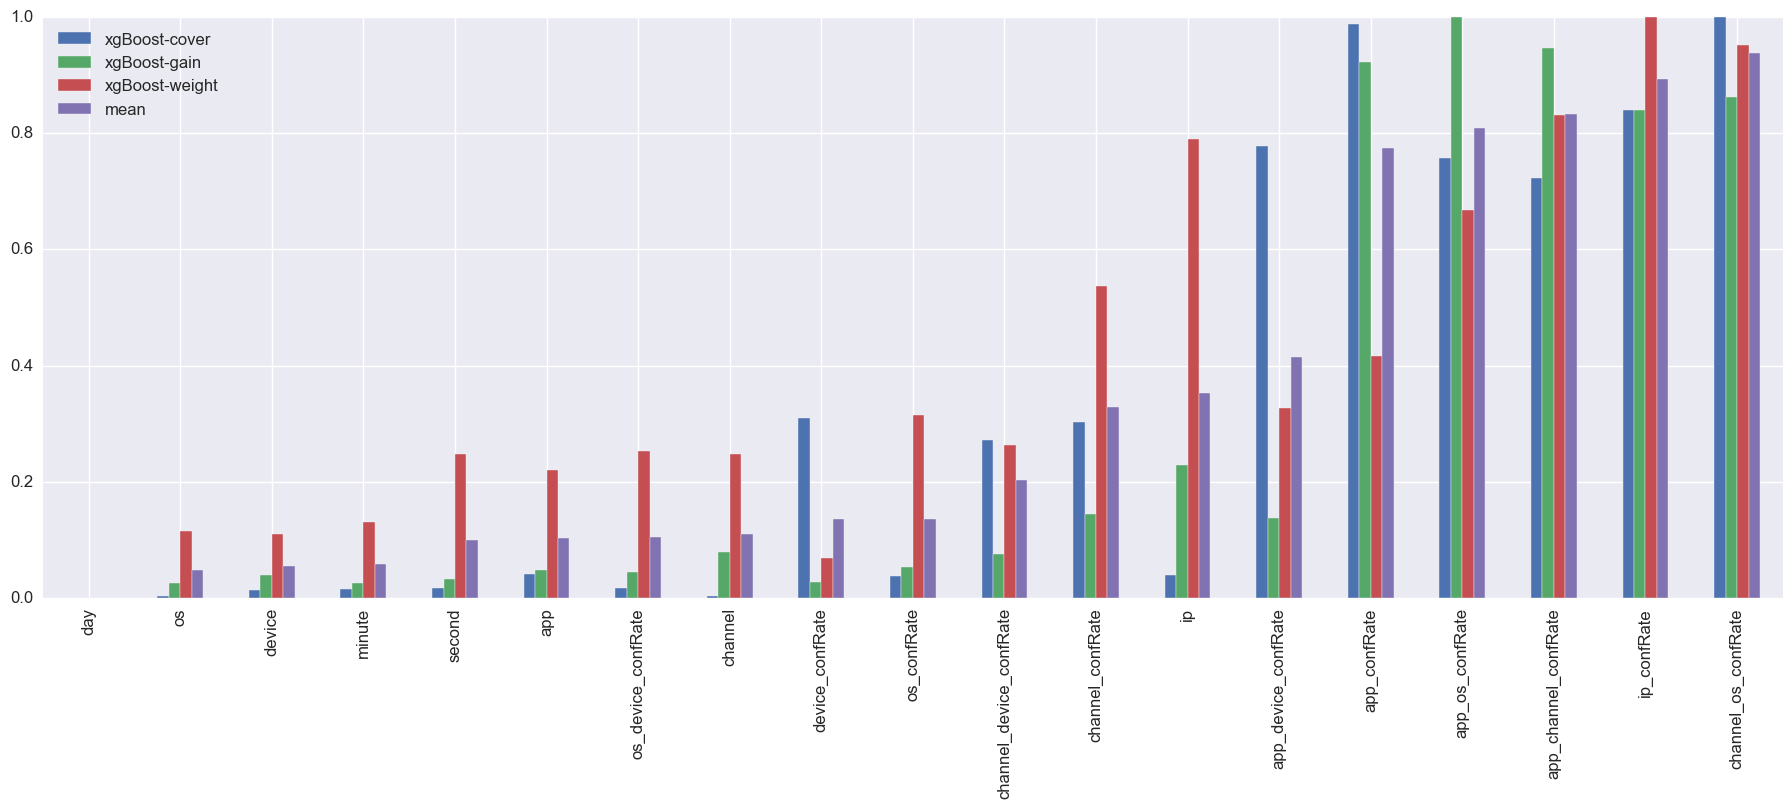

In [70]:
# Evaluating Feature Importance
# Having created heaps of features, I'll fit xgBoost to the data, and evaluate the feature importances. 

import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)
# The feature importances are MinMax scaled, put into a DataFrame, and finally plotted ordered by the mean feature importance.

from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))


In [71]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

In [72]:
# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nu

In [73]:
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os,ip_nunique_device,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,19,2,5,1,34,16,0,0,0,1.333333
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,20,3,8,1,34,11,0,0,0,1.000000
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,17,2,6,3,34,10,0,0,0,2.000000
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,31,2,18,6,26,24,0,0,0,1.000000
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,1,1,1,1,34,1,0,0,0,NaN


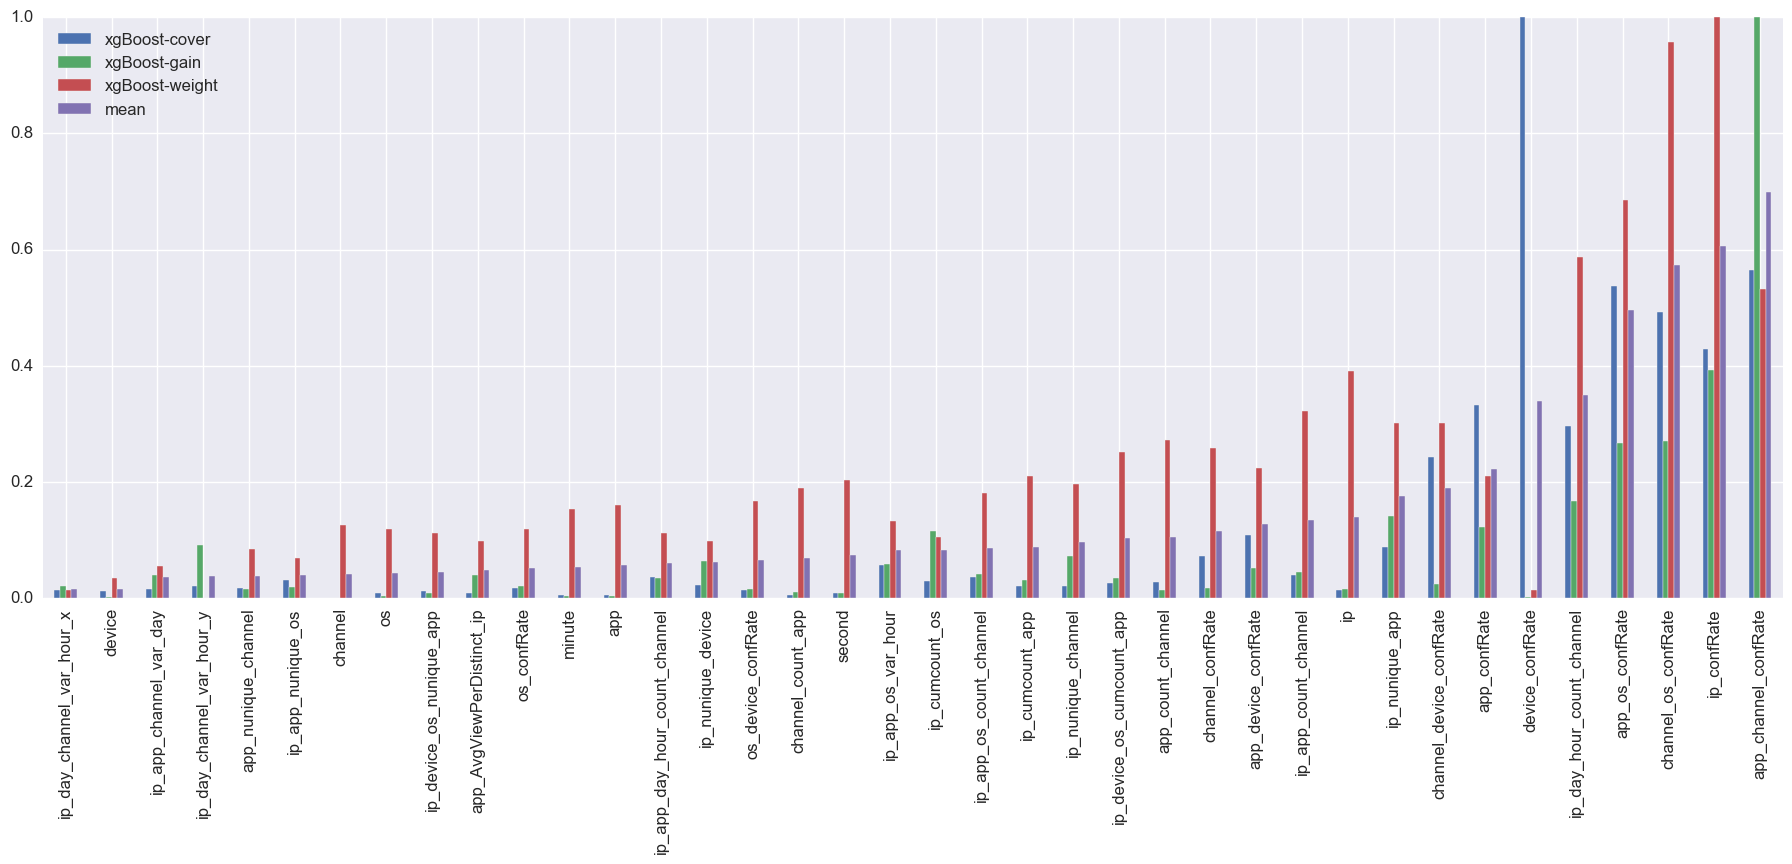

In [74]:
# Evaluating Feature Importance
# Having created heaps of features, I'll fit xgBoost to the data, and evaluate the feature importances. First split into X and y

import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)
# The feature importances are MinMax scaled, put into a DataFrame, and finally plotted ordered by the mean feature importance.

from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))
# Evaluation on Public Leaderboard

In [78]:
# Clicks on app ad before & after
# Has the user previously or subsequently clicked the exact same ip-app-device-os-channel? I thought that might be an interesting feature to test out as well.


HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,app_nunique_channel,ip_device_os_nunique_app,ip_device_os_cumcount_app,ip_cumcount_app,ip_cumcount_os,ip_day_channel_var_hour_y,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,6,14,...,34,16,0,0,0,1.333333,0,0,0,18
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,6,14,...,34,11,0,0,0,1.000000,0,0,0,22
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,6,14,...,34,10,0,0,0,2.000000,0,0,0,9
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,6,14,...,26,24,0,0,0,1.000000,0,0,0,68
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,6,14,...,34,1,0,0,0,NaN,0,0,0,0


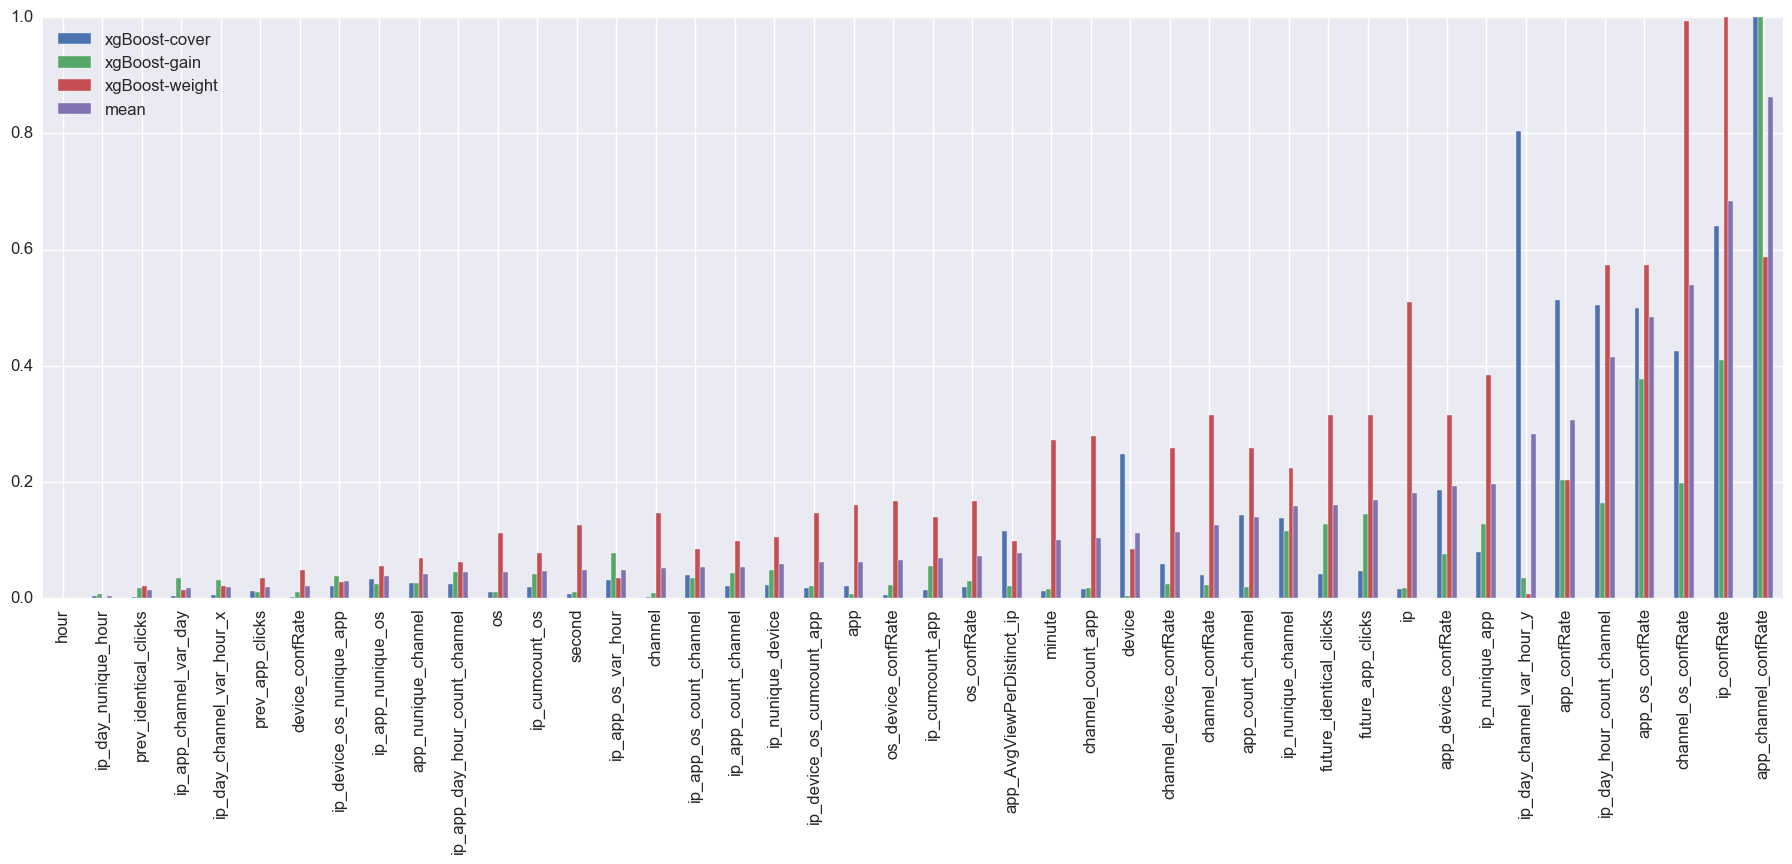

In [79]:
# Evaluating Feature Importance
# Having created heaps of features, I'll fit xgBoost to the data, and evaluate the feature importances. First split into X and y

import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)
# The feature importances are MinMax scaled, put into a DataFrame, and finally plotted ordered by the mean feature importance.

from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))
# Evaluation on Public Leaderboard